In [26]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

load_dotenv()

# Initialize model
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# Send a query
response = model.invoke("Tell me a joke.")

# Print just the text response
print(response.content)


Why did the scarecrow win an award?

Because he was outstanding in his field!


In [27]:
search_tool = TavilySearchResults(max_results=4)

tools = [search_tool]
print(search_tool.run("What is the weather in bangalore?"))

memory = MemorySaver()


[{'title': 'Bengaluru weather: Patchy rain, mild temperatures with moderate ...', 'url': 'https://timesofindia.indiatimes.com/city/bengaluru/bangalore-weather-update-pleasant-rainy-day-ahead-with-comfortable-temperatures/articleshow/123593650.cms', 'content': "Bengaluru is expected to have mild and damp weather on August 30, 2025, with temperatures ranging from 19.8°C to 26.2°C. Patchy rain is forecasted throughout the day, and humidity will be around 78%. The city's air quality is favorable, with an AQI of 41, making morning hours ideal for outdoor activities. The upcoming week indicates consistent rainfall and fluctuating temperatures. [...] The data for this weather forecast has been sourced from AQI.in, providing residents with comprehensive information to plan their daily activities and weekly schedules accordingly.Bengaluru is set to experience mild and damp weather on August 30, 2025, with temperatures ranging from 19.8°C to 26.2°C and patchy rain expected throughout the day. Th

In [28]:
llm_with_tools = model.bind_tools(tools)



In [29]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
     # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)
    

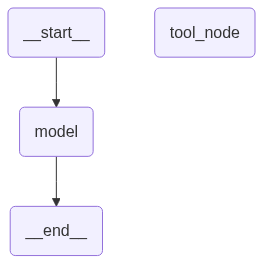

In [30]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


In [ ]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='0ddac7e9-21a8-4daa-a0a2-ec76c7d02ce2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "next SpaceX launch"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--4a26c90d-2c56-4acf-8253-be7ab7f63af8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch'}, 'id': 'daf517bf-eb89-487b-b7fe-ef2090ade905', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 92, 'total_tokens': 174, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 69}}),
  ToolMessage(content='[{\'title\': \'SpaceX Starship Flight 10 launch: Live updates\', \'url\': \'https://www.space.com/news/live/spacex-starship-mission

In [32]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '29527f60-4a0d-4f3f-92df-724df636e46d', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='c8f945c3-0515-4fab-a5f6-5f52d8a5bd43')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '21566344-6347-4326-940e-f413695a0c2e', 'metadata': {'thread_id': 8, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:4b773c3a-4b7c-222f-1730-69632cf87785'}, 'parent_ids': ['29527f60-4a0d-4f3f-92df-724df636e46d']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='When is the next spa